In [9]:
%matplotlib inline 

from __future__ import division
import pandas, numpy, csv, re

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from cStringIO import StringIO
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr

import seaborn as sb
import matplotlib.patches as mpatches #for the plot legend
import os
import collections

This my adaptation of Bo's suggested DeMixQ processing.

Uses as input a subset of the FITExP dataset. DeMixQ is run in TOPPAS. 
Requires a consensus csv file of the aligned and matched features across all maps and the EICExtractor output file
where ion signals are recovered from a window of RT and mz around the consensus features

In [2]:
consensus_txt = r"/home/vital/FITExP_dataset/deMixQ_FITExP_subset/TOPPAS_out_FeaturePIP_IonPIP/015-TextExporter-out/CMV_10march013_a375_5fu_a_72h_set2_rep5.csv"
eic_txt = r"/home/vital/FITExP_dataset/deMixQ_FITExP_subset/TOPPAS_out_FeaturePIP_IonPIP/019-EICExtractor-out/CMV_10march013_a375_5fu_a_72h_set2_rep5.csv"

In [12]:
num_samples = 4
num_replica = 3

In [6]:
def read_consensus(fn):
    '''
    Read text table from consensusXML exported by OpenMS TextExporter
    '''
    cons_header = []
    pept_header = []
    runs_name = []

    # fetch the headers for consensus features, unassigned peptides and experiments' names. 
    for row in csv.reader(open(fn), delimiter='\t'):
        if row[0] == '#CONSENSUS':
            cons_header = row
        elif row[0] == '#UNASSIGNEDPEPTIDE':
            pept_header = row
        elif row[0] == 'MAP':
            runs_name.append(row[2].split("/")[-1].split(".")[0])

    # read consensus features
    s = StringIO()
    with open(fn) as fh:
        for line in fh:
            if line.startswith("CONSENSUS"):
                s.write(line)
    s.seek(0)
    cons = pandas.read_csv(s, sep='\t', header=None, names=cons_header)
    co_peps = []
    with open(fn) as fh:
        for line in fh:
            if line.startswith("CONSENSUS"):
                co_peps.append('')
            elif line.startswith('PEPTIDE') and co_peps[-1] == '':
                # choose the first recorded peptide sequence as consensus sequence
                co_peps[-1] = line.split("\t")[5]
    cons['peptide_0'] = co_peps

    # read uassigned peptides as consensus features
    s = StringIO()
    with open(fn) as fh:
        for line in fh:
            if line.startswith("UNASSIGNEDPEPTIDE"):
                s.write(line)
    s.seek(0)
    ua_peps = pandas.read_csv(s, sep='\t', header=None, names=pept_header)
    ua_peps = ua_peps.groupby(['sequence', 'charge']).mean()

    return cons, ua_peps, runs_name

In [4]:
def read_eic(fn):
    '''
    Read the detailed output file from EIC extraction in OpenMS.
    Two isotopic peaks (M and M+1) are extracted for each consensus feature and unassigned peptide
    Calculate geometric average of intensities from the two isotopic peaks, as well as diviations of RT and mass.
    '''

    with open(fn) as fh:
        eic_str = [StringIO() for _ in range(4)]
        sample_header = [i for i in fh.next().rstrip().split(',') if i] # sample row
        fh.next() # empty row
        cols = fh.next().rstrip().split(',') # quantity headers
        for ix in range(2, len(cols)):
            i = int((ix-2)/5)
            cols[ix] = '_'.join([sample_header[i], cols[ix]]) # rename columns according to sample names

        ix = 0
        for line in fh:
            eic_str[ix % 4].write(line)
            ix += 1

        [sio.seek(0) for sio in eic_str]

    # obtain quantities from M and M+1 of target and decoy features, separately.
    eic = pandas.read_csv(eic_str[0], header=None, names=cols) # Monoisotopic    
    eic_iso = pandas.read_csv(eic_str[1], header=None, names=cols) # 13C isotope
    eic_decoy0 = pandas.read_csv(eic_str[2], header=None, names=cols)
    eic_decoy1 = pandas.read_csv(eic_str[3], header=None, names=cols)
    
    for samp in sample_header:
        int_ix = samp + '_intensity'
        rt_ix = samp + '_dRT'
        ppm_ix = samp + '_dppm'

        # values of target features
        eic[samp + '_int_1'] = (eic[int_ix] * eic_iso[int_ix]) ** 0.5
        eic[samp + '_dRT_1'] = eic[rt_ix] - eic_iso[rt_ix]
        eic[samp + '_ppm_1'] = eic[ppm_ix] - eic_iso[ppm_ix]

        # values of decoy features
        eic[samp + '_int_d1'] = (eic_decoy0[int_ix] * eic_decoy1[int_ix]) ** 0.5
        eic[samp + '_dRT_d0'] = eic_decoy0[rt_ix] 
        eic[samp + '_dRT_d1'] = eic_decoy0[rt_ix] - eic_decoy1[rt_ix]
        eic[samp + '_ppm_d0'] = eic_decoy0[ppm_ix]
        eic[samp + '_ppm_d1'] = eic_decoy0[ppm_ix] - eic_decoy1[ppm_ix]

    return eic

In [5]:
def median_shift(dat, rcol, scol, knn=15, span=500):
    '''
    Predict median shift (fold-change) of ion intensity at a given RT, using KNN regression
    rcol: column of global medians
    scol: columm of extracted intensities of one sample
    knn:  number of k nearest neighbors  
    span: number of features for median shift calculation. 
    '''

    d = dat[(dat[scol] > 0) & (dat[rcol] > 0)].sort(columns=['rt_cf'])
    
    x = d['rt_cf'].values
    y = numpy.log2(d[scol] / d[rcol]) # fold-change

    X = numpy.array([numpy.mean(x[i:i+span]) for i in range(0, len(x), int(span/10))])
    y = numpy.array([numpy.median(y[i:i+span]) for i in range(0, len(x),int(span/10))])
    reg = KNeighborsRegressor(n_neighbors=knn)
    reg.fit(numpy.matrix(X).T, numpy.matrix(y).T)
    
    return reg, X, y

In [7]:
eic = read_eic(eic_txt)
cons, uapep, ic0 = read_consensus(consensus_txt)
ic0 = sorted(ic0)

# replace Intensity Column names
icols = [i for i in cons.columns if i.startswith('intensity_')]
cons = cons[icols + ['quality_cf', 'peptide_0', 'charge_cf', 'rt_cf', 'mz_cf']]
cons.rename(columns=dict(zip(icols[1:], ic0)), inplace=True)

# please pardon me for the confusing variable namings here.
# ic1x => feature Intensity Column 1 :XIC (geometric average of M and M+1) 
ic1x = sorted([i for i in eic.columns if i.endswith('int_1')])

# column names of consensus (targets)
#crt0 => rt difference between consensus f and found eic
crt0 = sorted([i for i in eic.columns if i.endswith('dRT')])
#crt1 => rt difference between monoisotopic found eic and C13 found eic
crt1 = sorted([i for i in eic.columns if i.endswith('dRT_1')])
#cppm0 => mz difference (in ppm) between consensus f and found eic
cppm0 = sorted([i for i in eic.columns if i.endswith('ppm')])
#cppm1 => mz difference (in ppm) between monoisotopic found eic and C13 found eic
cppm1 = sorted([i for i in eic.columns if i.endswith('ppm_1')])

# column names of decoys
dic1x = sorted([i for i in eic.columns if i.endswith('int_d1')])
drt0 = sorted([i for i in eic.columns if i.endswith('dRT_d0')])
drt1 = sorted([i for i in eic.columns if i.endswith('dRT_d1')])
dppm0 = sorted([i for i in eic.columns if i.endswith('ppm_d0')])
dppm1 = sorted([i for i in eic.columns if i.endswith('ppm_d1')])

In [8]:
# combine Feature and XIC into dataframe_X
dx = pandas.concat([eic, cons], axis=1)
dx['peptide_0'] = [i for i in cons.peptide_0]  + [ i[0] for i in uapep.index.tolist()]
dx['charge_cf'] = [i for i in cons.charge_cf]  + [ i[1] for i in uapep.index.tolist()]
dx['mz_cf'] = [i for i in cons.mz_cf] + uapep.mz.tolist()
dx['rt_cf'] = [i for i in cons.rt_cf] + uapep.rt.tolist()
dx = dx[dx.rt_cf > 0]

dx['peptide'] = [ re.sub('C\(Carbamidomethyl\)', 'C', str(i)) for i in dx.peptide_0]
dx['baseseq'] = [ re.sub('\(.+?\)', '', str(i)) for i in dx.peptide_0]

dx['mods'] = [ sorted(re.findall('\(.+?\)', str(i))) for i in dx.peptide ]
dx['uniq'] = [ "%s%d%s" % (x.baseseq, x.charge_cf, ''.join(x.mods)) for i, x in dx.iterrows()]

# cross-run quantifications from feature-based linking.
dx['f_overlap'] = [ numpy.count_nonzero(numpy.nan_to_num(i)) for i in dx[ic0].values ]
# cross-run quantifications from ion-based linking. 
dx['e_overlap'] = [ numpy.count_nonzero(i) for i in dx[ic1x].values ]
# median intensity in each individual run
dx['medianEIC'] = dx[ic1x].median(axis=1)

print "number of features:\t", len(dx)
print "number of runs:\t", len(ic1x)

number of features:	220944
number of runs:	12


In [10]:
# XIC extraction rate for consensus features
e = numpy.array(dx[dx.intensity_cf.isnull() == False].e_overlap).tolist() 
print e.count(len(ic1x)) * 100 / len(e), "% of ", len(e)
#Of all the consensus features (identified or not), for this % I can find ion signal (EIC extraction) 
# in all the runs

51.8565036898 % of  198249


In [13]:
# Reference set: consensus features with no missing values in both feature linking and XIC extraction
refdx = dx[(dx.f_overlap ==len(ic0)) & (dx.e_overlap == len(ic0))]

#crt0 => rt difference between consensus f and found eic (DeltaT1 in the paper)
#crt1 => rt difference between monoisotopic found eic and C13 found eic, (DeltaT2 in the paper)
#cppm0 => mz difference (in ppm) between consensus f and found eic (DeltaM1 in the paper)
#cppm1 => mz difference (in ppm) between monoisotopic found eic-signal and C13 found eic-signal (DeltaM2)
fcol = numpy.concatenate([crt0, crt1, cppm0, cppm1])
dcol = numpy.concatenate([drt0, drt1, dppm0, dppm1])

# unit-less transformation. From the paper:
#Since these factors have different units and intervals of changes,#are normalized by their own stdev 
#and thus converted to unitless quantities that can be simply combined

refz = (refdx[fcol] - refdx[fcol].mean()) / refdx[fcol].std()
decoyz = (refdx[dcol] - refdx[fcol].mean().values) / refdx[fcol].std().values
testz = (dx[fcol] - refdx[fcol].mean()) / refdx[fcol].std()

for i in numpy.array(ic1x).reshape(num_samples, num_replica):
    cv = refdx[i].std(axis=1) / refdx[i].mean(axis=1)
    cv = numpy.sqrt(cv)
    for run_id in i:
        refz[run_id + '_cv'] = cv

for i in numpy.array(dic1x).reshape(num_samples, num_replica):
    cv = refdx[i].std(axis=1) / refdx[i].mean(axis=1)
    cv = numpy.sqrt(cv)
    for run_id in i:
        decoyz[run_id + '_cv'] = cv

for i in numpy.array(ic1x).reshape(num_samples, num_replica):
    cv = dx[i].std(axis=1) / dx[i].mean(axis=1)
    cv = numpy.sqrt(cv)
    for run_id in i:
        testz[run_id + '_cv'] = cv

ccv = [i for i in refz.columns if i.endswith('cv')]
dcv = [i for i in decoyz.columns if i.endswith('cv')]

#For the Reference set:
#average difference, for each sample, between the consensus mz and the extracted ion mz. 
#print refdx[cppm0].mean()

#STD, for each sample, between the consensus mz and the extracted ion mz
#print refdx[cppm0].std()

#And for the whole set:
#print dx[cppm0].mean()
#print dx[cppm0].std()

#average difference, for each sample, between the consensus RT and the extracted ion RT
#print refdx[crt0].mean()
#STD, for each sample, between the consensus mz and the extracted ion mz
#print refdx[crt0].std()

#And for the whole set:
#print dx[crt0].mean()
#print dx[crt0].std()

In [14]:
fil_cols = zip(ic1x, crt0, crt1, cppm0, cppm1, ccv)
fil_cols_decoy = zip(dic1x, drt0, drt1, dppm0, dppm1, dcv)


zscores = []
for f in fil_cols:
    e = refdx[f[0]] > 0
    rz = refz[e]
    z = [numpy.sum(v*v) for v in rz[list(f[1:])].values]
    zscores = zscores + z

dzscores = []
for f in fil_cols_decoy:
    e = refdx[f[0]] > 0
    dd = decoyz[e]
    z = [numpy.sum(v*v) for v in dd[list(f[1:])].values]
    dzscores = dzscores + z

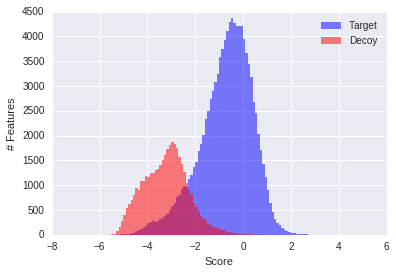

In [15]:
###PLOT FDR ION-PIP Score
bins = numpy.arange(-6.6, 4.5, 0.1)
pandas.Series(-numpy.log(zscores)).hist(bins=bins, alpha = 0.5, color ='b', lw=0, label='Target')
pandas.Series(-numpy.log(dzscores)).hist(bins=bins, alpha = 0.5, color='r', lw=0, label='Decoy')
# pandas.Series(-numpy.log(tzscores)).hist(bins=bins, alpha = 0.3, color='y', lw=0, label='All')
plt.legend()
plt.xlabel('Score')
plt.ylabel('# Features')
plt.show()

In [20]:
score_list = sorted(zip(zscores + dzscores, [0 for i in zscores] + [1 for i in zscores]), key=lambda x: x[0])
score_cutoff = 0
hit_count = 0
decoy_count = 0

# set FDR threshold 
fdr = 0.05
for s in score_list:
    hit_count += 1
    score_cutoff = -numpy.log(s[0])
    if s[1] > 0:
        decoy_count += 1
    if decoy_count / hit_count >= fdr:
        print "cutoff score:", score_cutoff
        break
        
#FILTER: Set to 0 extracted intensitiy for those features that have scores lower than score_cutoff:

#fil_cols = zip(ic1x, crt0, crt1, cppm0, cppm1, ccv)
# ic1x => EIC Intensity Column 1 :XIC (geometric average of M and M+1) 
for f in fil_cols:
    score = numpy.array([numpy.sum(v*v) for v in testz[list(f[1:])].values])
    score = -numpy.log(score)
    dx[f[0]][list(score <= score_cutoff)] = 0 
    # XIC filter: "The features that failed to pass the threshold were considered missing (zero-intensity)"

#dx['medianEIC'] = dx[dx[ic1x] > 0][ic1x].median(axis=1) #watch out : memory error!
dx['e_overlap'] = [ numpy.count_nonzero(i) for i in dx[ic1x].values ]

print "Features before filtering:\t", len(dx)     


cutoff score: -2.21166096557


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Features before filtering:	220944


In [21]:
#Remove features that failed to be quantified in at least one replicate in each sample:

ix = numpy.min([numpy.mean(dx[i].values, axis=1) for i in numpy.array(ic1x).reshape(num_samples, num_replica)], axis=0) > 0 

dx = dx[ix]

print "Features after filtering:\t", len(dx)
print "Unique peptide sequences:\t", len(dx.baseseq.unique())

Features after filtering:	70551
Unique peptide sequences:	17562


In [22]:
# Remove problematic runs with low correlation between feature abundance and XIC intensity.

icols = zip(ic0, ic1x)
for a in icols[:]:
    do = dx[pandas.notnull(dx[a[0]])]
    do = do[do[a[1]] > 0]
    xy = do[list(a)].apply(numpy.log2).values
    r2 = pearsonr(xy[:,0], xy[:, 1])[0] ** 2
    print a[1], len(xy), r2
    
    if r2 < 0.5:
        icols.remove(a)
        print a, " has been removed due to low correlation."

CMV_10march013_a375_5fu_a_72h_set2_rep5.mzML_int_1 34424 0.880138854972
CMV_10march013_a375_5fu_d_72h_set2_rep2.mzML_int_1 29690 0.88553732436
CMV_10march013_a375_5fu_d_march_72h_set2_rep4.mzML_int_1 30871 0.888260929527
CMV_10march013_a375_doxo_a_72h_set2_rep5.mzML_int_1 34303 0.881762025691
CMV_10march013_a375_doxo_d_72h_set2_rep2.mzML_int_1 30789 0.885501590473
CMV_10march013_a375_doxo_d_march_72h_set2_rep4.mzML_int_1 29929 0.873596055605
CMV_10march013_h1299_5fu_72h_set3_rep1.mzML_int_1 32186 0.866576768241
CMV_10march013_h1299_5fu_72h_set3_rep2.mzML_int_1 29825 0.872439962806
CMV_10march013_h1299_5fu_72h_set3_rep3.mzML_int_1 32003 0.877747352459
CMV_10march013_h1299_doxo_72h_set3_rep1.mzML_int_1 20966 0.82949334341
CMV_10march013_h1299_doxo_72h_set3_rep2.mzML_int_1 23483 0.840076585219
CMV_10march013_h1299_doxo_72h_set3_rep3.mzML_int_1 23261 0.850729404065


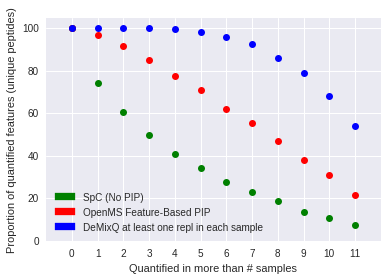

In [26]:
#Compare peptides/run obtained with deMixQ vs only feature-based PIP vs Identified (MS/MS, spectral count) #########################

# Output from FeatureLinkerUnlabeldQT -> ProteinQuantifier is a list of features WITH an assigned peptide.
# So, to make a fair comparison, pick feature and ion pip from dx WITH an assigned peptide:
dx_pep = dx[dx.baseseq != '']
dx_pep.drop_duplicates(subset=['uniq'], inplace=True)
dx_pep = dx_pep[ic0+ic1x+['baseseq', 'intensity_cf', 'mz_cf', 'rt_cf']]
#CHECK, For each sample, That either intensity_cf or intensity_i are present (or both) . In that case it is considered quantified in that sample:
icols = zip(ic0, ic1x)

for a, b in icols:
    dx_pep[a+"_q"] = dx_pep[a].fillna(0) + dx_pep[b]
q_cols = [c for c in dx_pep.columns if c.endswith("_q")]
dx_pep["f_e_overlap"] = [numpy.count_nonzero(i) for i in dx_pep[q_cols].values ]
dx_pep = dx_pep[dx_pep["f_e_overlap"] > 0 ]

#1-DeMixQ-count (Feature based PIP + Ion based PIP)
demixq_pip_count = [list(dx_pep.f_e_overlap > i).count(True) for i in range(len(ic0)) ]
percent_demixq_pip = [i*100/max(demixq_pip_count) for i in demixq_pip_count]

#2-Feature-based PIP (OpenMS: FeatureLinkerUnlabeledQT + ProteinQuantifier)
feature_pip = pandas.read_csv('/home/vital/FITExP_dataset/deMixQ_FITExP_subset/TOPPAS_out_FeaturePIP/ProteinQuantifier-out/quanti_pept_matrix.csv', skiprows=3, sep="\t")
abundance_cols = [c for c in feature_pip.columns if c.startswith("abundance")]
feature_pip["quant_count"] = [numpy.count_nonzero(numpy.nan_to_num(i)) for i in feature_pip[abundance_cols].values ]
feature_pip_count = [list(feature_pip.quant_count > i).count(True) for i in range(len(abundance_cols))]
percent_feature_pip = [i*100/max(feature_pip_count) for i in feature_pip_count]
#TO Be fair in the comparison I should only consider here features quantified in at least one repl in each sample

#3-Spectral counting (No PIP). Count peptides identified across runs
uniq_peps_arr = []
for id_file in os.listdir("/home/vital/FITExP_dataset/deMixQ_FITExP_subset/id_filter/"):
    if id_file.endswith(".csv"):
        id_file = "/home/vital/FITExP_dataset/deMixQ_FITExP_subset/id_filter/" + id_file
        peps = StringIO()
        peps_header = []
        with open(id_file) as fh:
            for line in fh:
                if line.startswith("#PEPTIDE"):
                    peps_header = line.split("\t")
                if line.startswith("PEPTIDE"):
                    peps.write(line)
        peps.seek(0)
        peps_df = pandas.read_csv(peps, sep='\t', header=None, names=peps_header)
        peps = [re.sub('\(.+?\)', '', str(i)) for i in peps_df.sequence]
        uniq_peps = list(set(peps))
        uniq_peps_arr.append(uniq_peps)
#flatten:
all_pep_seqs = [pepseq for sublist in uniq_peps_arr for pepseq in sublist]
pep_freq = collections.Counter(all_pep_seqs)
pep_count = collections.Counter(pep_freq.values())
p = pep_count.values()
sp_count = []
for i in range(len(p)):
    sp_count.append(sum([s for s in p[i:len(p)]]))
percent_spc = [i*100/max(sp_count) for i in sp_count]

g_patch = mpatches.Patch(color='green', label='SpC (No PIP)')
r_patch = mpatches.Patch(color='red', label='OpenMS Feature-Based PIP')
b_patch = mpatches.Patch(color='blue', label='DeMixQ at least one repl in each sample')

plt.plot(percent_spc, 'go')
plt.plot(percent_feature_pip, 'ro')
plt.plot(percent_demixq_pip, 'bo')

plt.xticks(numpy.arange(0, len(ic0), 1))
plt.xlabel("Quantified in more than # samples")
plt.ylim(0, 105)
plt.xlim([-1,12])
plt.ylabel("Proportion of quantified features (unique peptides)")
plt.legend(handles=[g_patch, r_patch, b_patch], loc=3)
plt.show()


In [27]:
#count total number of missing values
missing = dx_pep[q_cols][dx_pep[q_cols] == 0.000000e+00].count().sum()
#total 
total = dx_pep[q_cols].shape[0]*dx_pep[q_cols].shape[1]
#percent
print missing/total*100

10.5216951882


In [28]:
# log2 transform of selected intensity colums from the dataframe_X
data = dx[ic0 + ic1x].apply(numpy.log2)

#impute remaining missing values as the minimum detectable intensity (int_1):
#NOTE: This imputation is for -inf, which are the ic1x (int_1) cols (ion extracted intensities), NOT consensus(ic0) features intensities!
data[data==-numpy.inf] = data[data!=-numpy.inf][ic1x].min().min()

# or impute missing values as zero intensity
#data[data==-numpy.inf] = 0

data['rt'] = dx['rt_cf']
data['mass'] = dx['mz_cf'] * dx['charge_cf']
data['charge'] = dx['charge_cf']
data['peptide'] = dx.peptide
data['baseseq'] = dx.baseseq
data['uniq'] = dx.uniq 

for a, b in icols:
    dn = data[(data[a].notnull()) & (data[b] > 0)] #If impute int_1 with min intensity: all data[b] will be > 0 since I just imputed these (0 in dx, -inf in data, after log2) 
    mx = numpy.matrix(dn[[a,b,'mass']])
    # KNN regression (k=5 by default) for predicting feature abundance (log2) based on ion intensity and precosor mass
    regr = KNeighborsRegressor().fit(mx[:,1:], mx[:,0])
    a_ = regr.predict(numpy.matrix(data[[b, 'mass']]))[:,0]
    a_[data[b].values==0] = 0 # keep missing values from extraction
    data[a + '_'] = a_
ic2 = [a+'_' for a in ic0]
tmp = dx[ic0].apply(numpy.log2)
tmp.values[numpy.isnan(tmp.values)] = data[ic2].values[numpy.isnan(tmp.values)]
data[ic0] = tmp.apply(numpy.exp2) # converting back to linear scale

print data[ic0].values.flatten().tolist().count(1) * 1. / data[ic0].values.flatten().__len__()

#this data df wont have any missing value for feature abundance columns (ic0) and also no mv for eic columns (ic1)


0.0


32.3227168998 % features have been assigned with peptide sequence.


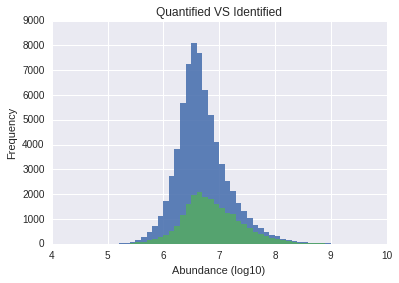

In [29]:
# quantified vs. identified
print len(data[data.peptide != '']) *100./ data[ic0].__len__(), "% features have been assigned with peptide sequence."
data[ic0].apply(numpy.log10).median(axis=1).hist(bins=numpy.arange(4,10,0.1), lw=0, alpha=0.9)
data[data.peptide != ''][ic0].apply(numpy.log10).median(axis=1).hist(bins=numpy.arange(4,10,0.1), lw=0, alpha=0.9)
plt.xlabel("Abundance (log10)")
plt.ylabel("Frequency")
plt.title("Quantified VS Identified")
plt.show()

In [ ]:
data1 = data.copy(deep=True)
for a, b in icols:
    reg, _, _ = median_shift(dx, 'medianEIC', b, knn=5, span=500)
    data1[a] = numpy.log2(data1[a]) - reg.predict(numpy.matrix(data1.rt).T).T[0]

# keep identified features    
pepdata = data1[data1.peptide != '']

# remove duplications
pepdata.drop_duplicates(subset=['uniq'], inplace=True)

# convert back to linear intensity space
pepdata[ic0] = 2 ** pepdata[ic0]

# remove modified peptides?
# pepdata = pepdata[[len(i) == 0 for i in pepdata.mods]]

# report matrix
mx = pepdata.groupby(['baseseq'])[ic0].sum()
for i in ic0:
    mx[i] = mx[i] / mx[i].mean() * mx[ic0].values.flatten().mean()

# save peptide-level quantification result to a CSV file
#mx.to_csv(r'../example/peptide_quant.csv')
#mx.to_csv(r'/home/vital/DeMixQ_example/peptide_quant.csv')
#mx.to_csv(r'/home/vital/FITExP_dataset/deMixQ_FITExP_subset/TOPPAS_out_FeaturePIP_IonPIP/peptide_quant.csv')

#### PROTEINS

After median-shift correction (RT-dependent abundance recalibration based on sliding windows of 500 features, 50step-size)

I can report a matrix:
mx.to_csv(r'/home/vital/FITExP_dataset/deMixQ_FITExP_subset/TOPPAS_out_FeaturePIP_IonPIP/peptide_quant.csv')

But if I want to aggregate peptides abundances into a protein abundance with diffacto I need a new column with the protein id

In [ ]:
from Bio import SeqIO
pep_quant = pandas.read_csv(r'/home/vital/FITExP_dataset/deMixQ_FITExP_subset/TOPPAS_out_FeaturePIP_IonPIP/peptide_quant.csv')
my_peptides = list(pep_quant.baseseq)
#look for my id in target db without contaminants so I only get target human proteins:
db_file = '/home/vital/TOPPAS_Create_Database/uniprot_human.fasta'

#db_handle = open(db_file, "rU")
#db_dict = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
#handle.close()

pep_protId_dict = {}
prot_Ids = []

for i in range(len(my_peptides)):
    for seq in SeqIO.parse(open(db_file), 'fasta'):
        if my_peptides[i] in seq.seq:
            prot_Ids.append(seq.id)
            pep_protId_dict[my_peptides[i]] = prot_Ids
    print "%s found in %s" % (my_peptides[i], prot_Ids)
    prot_Ids = []
seqs = pep_protId_dict.keys()
ids = [(", ").join(v) for v in pep_protId_dict.values()]
d = {'seq': seqs, 'id': ids }
pep_protId_df = pandas.DataFrame(data=d)

#merge on right so I wont keep peptides not found in my target human db (discard decoys and contaminants)
pep_quant = pandas.merge(pep_quant, pep_protId_df, left_on='baseseq', right_on='seq', how='right')

#for quantification remove peptides(rows) matching to more than one protein id
pep_quant = pep_quant[pep_quant["id"].str.contains(",") == False]

#To keep proteins with more than one peptide:
groups = pep_quant.groupby("id")
pep_quant = groups.filter(lambda g: len(g) > 1)
pep_quant.to_csv("pep_quant_multi_peps_per_prot.csv")

demixq_peps = pandas.read_csv("/home/vital/FITExP_dataset/deMixQ_FITExP_subset/pep_quant_multi_peps_per_prot.csv")
print len(demixq_peps.id.unique())
